In [1]:
import wandb
from datetime import datetime

In [2]:
lr = 1e-4
batch_size = 2
wd = 1e-5
pos_weight = 2
image_size = 256
# backbone="segmentation"
backbone="none"
vertical_type = "axial"
train_portion = 0.5
milestones = [50, 100, 150, 200]
model_name = "effdet"

slice_range=5

In [3]:
import os
import glob
import pydicom
import nibabel as nib
import pandas as pd
import numpy as np
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import math
from tqdm import tqdm
import random
from sklearn.utils import shuffle
from sklearn import metrics
from PIL import Image, ImageOps

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, CenterCrop
import torchvision.transforms.functional as TF
import torchvision.models as models

import timm

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

device = 'cuda' if torch.cuda.is_available() else 'cpu'
pos_weight = torch.tensor(pos_weight)

In [5]:
DATA_DIR = "/Volumes/SSD970/"
# DATA_DIR = "/root/autodl-tmp/cervical_spine/"
IMAGES_DIR = os.path.join(DATA_DIR, 'train_axial_images')

In [6]:
df = pd.read_csv(os.path.join(DATA_DIR, 'bbox_clean.csv'))
print(len(df))
df.head()

7203


,StudyInstanceUID,start_slice_number,axial_index,coronal_index,sagittal_index,aspect,pixel_spacing,z_spacing,is_flip,num_slices,x,y,width,height,slice_number
0,1.2.826.0.1.3680043.10051,1,132,226,227,2.461541,0.253906,0.625,0.0,272,219.27715,216.71419,17.30440,20.38517,133
1,1.2.826.0.1.3680043.10051,1,133,229,230,2.461541,0.253906,0.625,0.0,272,221.56460,216.71419,17.87844,25.24362,134
2,1.2.826.0.1.3680043.10051,1,134,234,230,2.461541,0.253906,0.625,0.0,272,216.82151,221.62546,27.00959,26.37454,135
3,1.2.826.0.1.3680043.10051,1,135,234,228,2.461541,0.253906,0.625,0.0,272,214.49455,215.48637,27.92726,37.51363,136
4,1.2.826.0.1.3680043.10051,1,136,237,227,2.461541,0.253906,0.625,0.0,272,214.00000,215.48637,27.00000,43.51363,137


In [7]:
def get_rectangle_edges_from_pascal_bbox(bbox):
    xmin_top_left, ymin_top_left, xmax_bottom_right, ymax_bottom_right = bbox

    # bottom_left = (xmin_top_left, ymax_bottom_right)
    width = xmax_bottom_right - xmin_top_left
    height = ymin_top_left - ymax_bottom_right

    return xmin_top_left, ymax_bottom_right, width, height

def draw_pascal_voc_bboxes(
        plot_ax,
        bboxes,
        get_rectangle_corners_fn=get_rectangle_edges_from_pascal_bbox,
):
    for bbox in bboxes:
        x, y, width, height = get_rectangle_corners_fn(bbox)
        # print(bbox)
        # x, y, width, height = bbox


        rect_1 = patches.Rectangle(
            (x, y),
            width,
            height,
            linewidth=4,
            edgecolor="black",
            fill=False,
        )
        rect_2 = patches.Rectangle(
            (x, y),
            width,
            height,
            linewidth=2,
            edgecolor="white",
            fill=False,
        )

        # Add the patch to the Axes
        plot_ax.add_patch(rect_1)
        plot_ax.add_patch(rect_2)

def show_image(
        image, bboxes=None, draw_bboxes_fn=draw_pascal_voc_bboxes, figsize=(10, 10)
):
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(image)

    if bboxes is not None:
        draw_bboxes_fn(ax, bboxes)

    plt.show()

# image = Image.open(os.path.join(IMAGES_DIR, '1.2.826.0.1.3680043.10051', '142.jpeg'))
# bboxes = [list(df.iloc[10][['x', 'y','width','height']])]
# print(bboxes)
# show_image(image, bboxes)

## Dataset Adaptor

In [8]:
class FractureDatasetAdaptor(Dataset):
    def __init__(self, images_dir_path, df):
        self.image_dir = images_dir_path
        self.df = df

    def __len__(self) -> int:
        return len(self.df)

    def get_image_and_labels_by_idx(self, idx):
        s = self.df.iloc[idx]
        # img = Image.open(os.path.join(self.images_dir_path, s['StudyInstanceUID'], f"{s['axial_index']}.jpeg"))

        UID = s['StudyInstanceUID']
        slice = s['axial_index']
        r = Image.open(os.path.join(self.image_dir, UID, f"{slice-1}.jpeg"))
        g = Image.open(os.path.join(self.image_dir, UID, f"{slice-0}.jpeg"))
        b = Image.open(os.path.join(self.image_dir, UID, f"{slice+1}.jpeg"))
        img = Image.merge('RGB', (r, g, b))

        pascal_bboxes = [[s.x, s.y, s.x + s.width, s.y + s.height]]
        class_labels = np.ones(1)

        return img, pascal_bboxes, class_labels, idx

    def show_image(self, index):
        image, bboxes, class_labels, image_id = self.get_image_and_labels_by_idx(index)
        print(f"image_id: {image_id}")
        show_image(image, bboxes)
        print(class_labels)

da = FractureDatasetAdaptor(IMAGES_DIR, df)
# da.show_image(2)

Creating the model


In [9]:
from effdet.config.model_config import efficientdet_model_param_dict
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet
from effdet.config.model_config import efficientdet_model_param_dict

In [10]:
print(f'number of configs: {len(efficientdet_model_param_dict)}')

list(efficientdet_model_param_dict.keys())[::3]

number of configs: 47


['efficientdet_d0',
 'efficientdet_d3',
 'efficientdetv2_dt',
 'cspresdet50',
 'cspdarkdet53',
 'mixdet_l',
 'mobiledetv3_large',
 'efficientdet_q2',
 'efficientdet_em',
 'tf_efficientdet_d1',
 'tf_efficientdet_d4',
 'tf_efficientdet_d7',
 'tf_efficientdet_d1_ap',
 'tf_efficientdet_d4_ap',
 'tf_efficientdet_lite1',
 'tf_efficientdet_lite3x']

In [11]:
timm.list_models('tf_efficientnetv2_*')


['tf_efficientnetv2_b0',
 'tf_efficientnetv2_b1',
 'tf_efficientnetv2_b2',
 'tf_efficientnetv2_b3',
 'tf_efficientnetv2_l',
 'tf_efficientnetv2_l_in21ft1k',
 'tf_efficientnetv2_l_in21k',
 'tf_efficientnetv2_m',
 'tf_efficientnetv2_m_in21ft1k',
 'tf_efficientnetv2_m_in21k',
 'tf_efficientnetv2_s',
 'tf_efficientnetv2_s_in21ft1k',
 'tf_efficientnetv2_s_in21k',
 'tf_efficientnetv2_xl_in21ft1k',
 'tf_efficientnetv2_xl_in21k']

In [12]:
def create_model(num_classes=1, image_size=512, architecture="tf_efficientnetv2_l"):
    efficientdet_model_param_dict['tf_efficientnetv2_l'] = dict(
        name='tf_efficientnetv2_l',
        backbone_name='tf_efficientnetv2_l',
        backbone_args=dict(drop_path_rate=0.2),
        num_classes=num_classes,
        url='', )

    config = get_efficientdet_config(architecture)
    config.update({'num_classes': num_classes})
    config.update({'image_size': (image_size, image_size)})

    print(config)

    net = EfficientDet(config, pretrained_backbone=True)
    net.class_net = HeadNet(
        config,
        num_outputs=config.num_classes,
    )
    return DetBenchTrain(net, config)

model = create_model()

{'name': 'tf_efficientnetv2_l', 'backbone_name': 'tf_efficientnetv2_l', 'backbone_args': {'drop_path_rate': 0.2}, 'backbone_indices': None, 'image_size': [512, 512], 'num_classes': 1, 'min_level': 3, 'max_level': 7, 'num_levels': 5, 'num_scales': 3, 'aspect_ratios': [[1.0, 1.0], [1.4, 0.7], [0.7, 1.4]], 'anchor_scale': 4.0, 'pad_type': 'same', 'act_type': 'swish', 'norm_layer': None, 'norm_kwargs': {'eps': 0.001, 'momentum': 0.01}, 'box_class_repeats': 3, 'fpn_cell_repeats': 3, 'fpn_channels': 88, 'separable_conv': True, 'apply_resample_bn': True, 'conv_bn_relu_pattern': False, 'downsample_type': 'max', 'upsample_type': 'nearest', 'redundant_bias': True, 'head_bn_level_first': False, 'head_act_type': None, 'fpn_name': None, 'fpn_config': None, 'fpn_drop_path_rate': 0.0, 'alpha': 0.25, 'gamma': 1.5, 'label_smoothing': 0.0, 'legacy_focal': False, 'jit_loss': False, 'delta': 0.1, 'box_loss_weight': 50.0, 'soft_nms': False, 'max_detection_points': 5000, 'max_det_per_image': 100, 'url': ''}

## Dataset

{'bboxes': tensor([[216.7142, 275.4185, 237.0994, 292.7228]]), 'labels': tensor([1.], dtype=torch.float64), 'image_id': tensor([0]), 'img_size': (512, 512), 'img_scale': tensor([1.])}


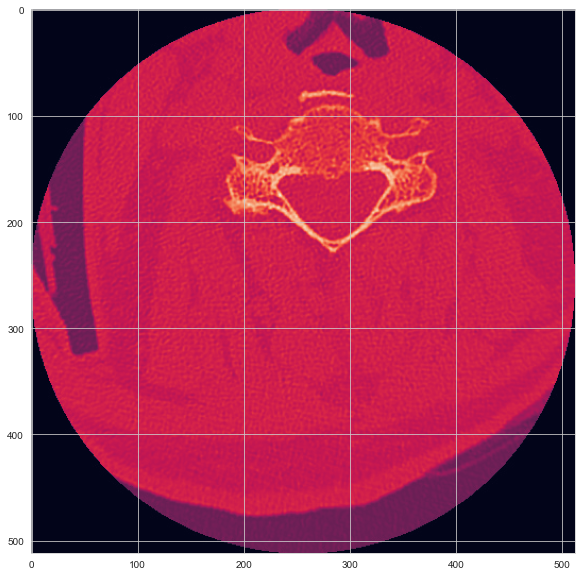

In [13]:
def get_train_transforms(target_img_size=512):
    return A.Compose(
        [
            A.HorizontalFlip(p=0.5),
            A.Resize(height=target_img_size, width=target_img_size, p=1),
            # A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            A.Normalize(0.5, 0.5),
            ToTensorV2(p=1),
        ],
        p=1.0,
        bbox_params=A.BboxParams(
            format="pascal_voc", min_area=0, min_visibility=0, label_fields=["labels"]
        ),
    )


def get_valid_transforms(target_img_size=512):
    return A.Compose(
        [
            A.Resize(height=target_img_size, width=target_img_size, p=1),
            # A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            A.Normalize(0.5, 0.5),
            ToTensorV2(p=1),
        ],
        p=1.0,
        bbox_params=A.BboxParams(
            format="pascal_voc", min_area=0, min_visibility=0, label_fields=["labels"]
        ),
    )

class EfficientDetDataset(Dataset):
    def __init__(
            self, dataset_adaptor, transforms=get_valid_transforms()
    ):
        self.ds = dataset_adaptor
        self.transforms = transforms

    def __getitem__(self, index):
        (
            image,
            pascal_bboxes,
            class_labels,
            image_id,
        ) = self.ds.get_image_and_labels_by_idx(index)

        sample = {
            "image": np.array(image, dtype=np.float32),
            "bboxes": pascal_bboxes,
            "labels": class_labels,
        }

        sample = self.transforms(**sample)
        sample["bboxes"] = np.array(sample["bboxes"])
        image = sample["image"]
        # pascal_bboxes = sample["bboxes"]
        labels = sample["labels"]

        _, new_h, new_w = image.shape
        sample["bboxes"][:, [0, 1, 2, 3]] = sample["bboxes"][
                                            :, [1, 0, 3, 2]
                                            ]  # convert to yxyx

        target = {
            "bboxes": torch.as_tensor(sample["bboxes"], dtype=torch.float32),
            "labels": torch.as_tensor(labels),
            "image_id": torch.tensor([image_id]),
            "img_size": (new_h, new_w),
            "img_scale": torch.tensor([1.]),
            # "img_scale": [1., 1.],
        }

        return image, target, image_id

    def __len__(self):
        return len(self.ds)

train_dataset = EfficientDetDataset(da, transforms=get_train_transforms())
img, ann, idx = train_dataset[0]
print(ann)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(img[0, :, :])
# print(ann['bboxes'])
# draw_pascal_voc_bboxes(ax, ann['bboxes'])


In [14]:
def collate_fn(batch):
    images, targets, image_ids = tuple(zip(*batch))
    images = torch.stack(images)
    images = images.float()

    boxes = [target["bboxes"].float() for target in targets]
    labels = [target["labels"].float() for target in targets]
    img_size = torch.tensor([target["img_size"] for target in targets]).float()
    img_scale = torch.tensor([target["img_scale"] for target in targets]).float()

    annotations = {
        "bbox": boxes,
        "cls": labels,
        "img_size": img_size,
        # "img_scale": img_scale,
    }

    return images, annotations, targets, image_ids

In [15]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    # shuffle=True,
    shuffle=False,
    pin_memory=True,
    drop_last=True,
    # num_workers=min(os.cpu_count(), 16),
    collate_fn=collate_fn,
)

In [16]:
images, annotations, _, image_ids = next(iter(train_loader))
print(annotations)
# print(_)
# print(image_ids)

{'bbox': [tensor([[216.7142, 219.2771, 237.0994, 236.5815]]), tensor([[216.7142, 272.5569, 241.9578, 290.4354]])], 'cls': [tensor([1.]), tensor([1.])], 'img_size': tensor([[512., 512.],
        [512., 512.]])}


In [20]:
loss = model(images, annotations)
print(loss)

torch.Size([36864, 4])
[64, 64, -1]


RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.